# Self - Organizing Map Analysis and Clustering

This notebook includes analysis and clustering of closed questions with Self-organizing map algorithm. The data was first preprocessed in separate notebook named "CoC preprocessing".

The final variables for SOM are:

* Relationship_to_the_faculty = "Relationship to the Faculty"
* Fluency_in_Finnish = "How fluent do you consider yourself in Finnish?"
* Gender_Female = "Female gender"
* Gender_Male = "Male gender"
* Gender_Other = "Other gender"
* Gender_NA = "Gender: Don't want to answer"
* feel_positive = "In general, I feel very positive about the Faculty"
* treated_fairly = "I am treated fairly at the Faculty"
* safe  = "I feel safe at the Faculty"
* connected_comm = "I feel connected to some community at the Faculty"
* positive_role = "In general, I feel very positive about my role at the Faculty"
* failure = "At times, I feel like I am a failure in my work or studies"
* close_people = "I feel close to people at the Faculty"
* support_each_other = "People at the Faculty support each other"
* support_me = "People at the Faculty support me"
* respect_each_other = "People at the Faculty treat each other with respect"
* respect_me = "People at the Faculty treat me with respect"
* appr_each_other = "People at the Faculty appreciate each other"
* appr_me = "People at the Faculty appreciate me"


Final number of observations (N = 82) because 3 out of 85 were excluded based on almost full missingness.
Variables include 3 background questions and 13 closed questions with Likert scale.
All the variables are numeric variables and are scaled for further analysis.

In [1]:
pacman::p_load(tidyverse, tidyr, dplyr, sjlabelled, factoextra, kohonen) # load R package

In [2]:
#set directory
path <- c("~/Documents/R/CoC")
setwd(path)

In [3]:
#read processed data gained from CoC preprocessing notebook 
data <- readRDS(file = "data/CoC_processed.rds", refhook = NULL)
head(data)

Relationship_to_the_faculty Fluency_in_Finnish feel_positive treated_fairly
1 3                           5                  1             1             
2 1                           5                  4             2             
3 3                           5                  2             4             
4 1                           5                  4             5             
5 0                           5                  4             4             
6 4                           5                  5             5             
  safe connected_comm positive_role failure close_people support_each_other
1 5    1              1             2       1            2                 
2 5    4              2             4       4            4                 
3 5    3              3             1       2            2                 
4 5    5              5             4       4            5                 
5 4    3              4             5       2            4                 
6 5    5              5             1       5            5                 
  support_me respect_each_other respect_me appr_each_other appr_me
1 2          2                  1          2               2      
2 4          2                  3          2               3      
3 3          3                  3          3               3      
4 5          5                  5          5               5      
5 4          4                  4          3               4      
6 5          5                  5          5               5      
  Gender_Don’t want to answer Gender_Female Gender_Male Gender_Other
1 0                           0             1           0           
2 0                           1             0           0           
3 0                           1             0           0           
4 0                           1             0           0           
5 0                           1             0           0           
6 0                           0             1           0

In [4]:
#set colours for future SOMs
coolBlueHotRed <- function(n, alpha = 1) {
  rainbow(n, end=4/6, alpha=alpha)[n:1]
}

pretty_palette <- c("#1f77b4","#ff7f0e","#2ca02c",
                    "#d62728","#9467bd","#8c564b","#e377c2")

## SOM with only closed questions (Likert-scale)

First, we create data matrix and scale the data. 
Then we set the size of grid of our own choise.

In [5]:
#create data set for training
data_train <- data[3:15]

#create data matrix and scale data
data_train_matrix <- scale(as.matrix(data_train)) #scaling is done by mean/st.deviation

#set the size of grid

##size of grid is selected by the researcher usually 
##but one of the approaches to count the appropriate size is 5*sqrt(n) where n is number of observations(rows)

#set the size of grid
xdim <- 5
ydim <- 9

#create grid
som_grid <- somgrid(xdim = xdim, ydim = ydim, neighbourhood.fct = "gaussian", topo="hexagonal")

Now we create SOM model and print its characteristics. 

In [6]:
#create SOM model including NAs
set.seed(1118)
som_model <- supersom(data_train_matrix, 
                      grid=som_grid, 
                      rlen = 500, #set experimentally
                      alpha = c(0.05, 0.01), 
                      dist.fcts = "euclidean",
                      maxNA.fraction = .9, #set the maximum fraction of NA to prevent the row to be removed
                      keep.data = TRUE) #keep the data in the som object


#print the summary of the model
summary(som_model)

SOM of size 5x9 with a hexagonal topology and a gaussian neighbourhood function.
The number of data layers is 1.
Distance measure(s) used: euclidean.
Training data included: 82 objects.
Mean distance to the closest unit in the map: 1.429.


Red colour presents the highest value for the variable, blue colour - the lowest.

Then we create the heatmap for each variable.

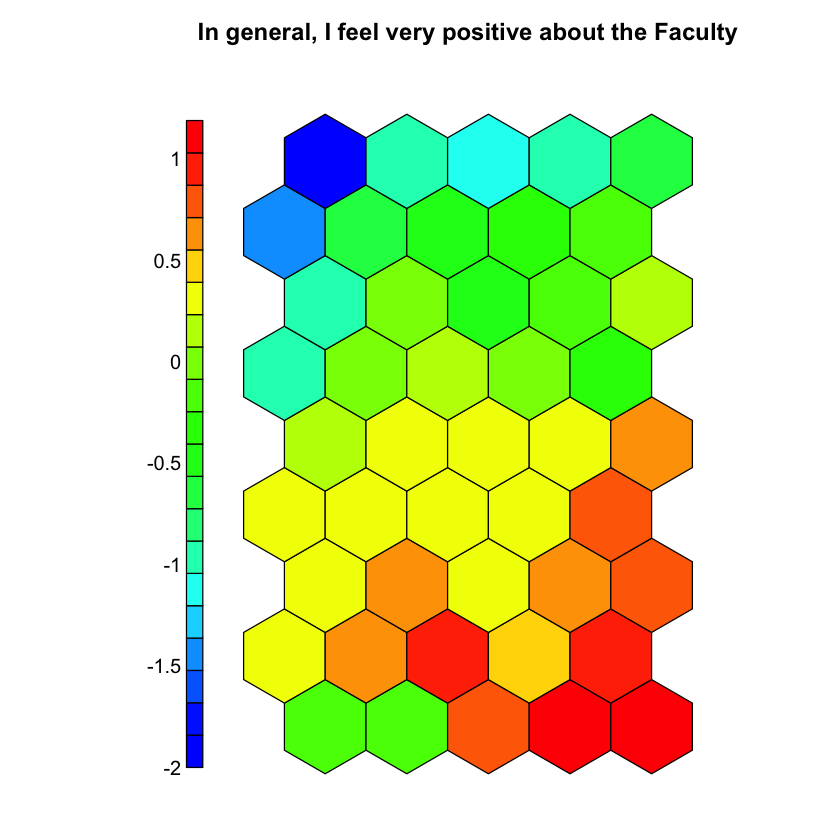

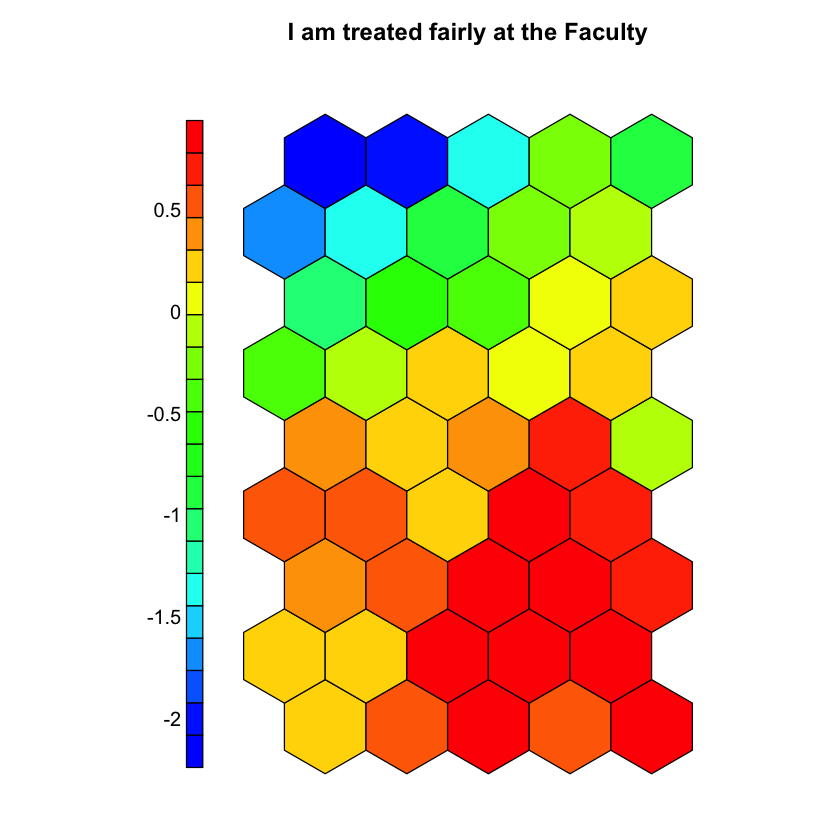

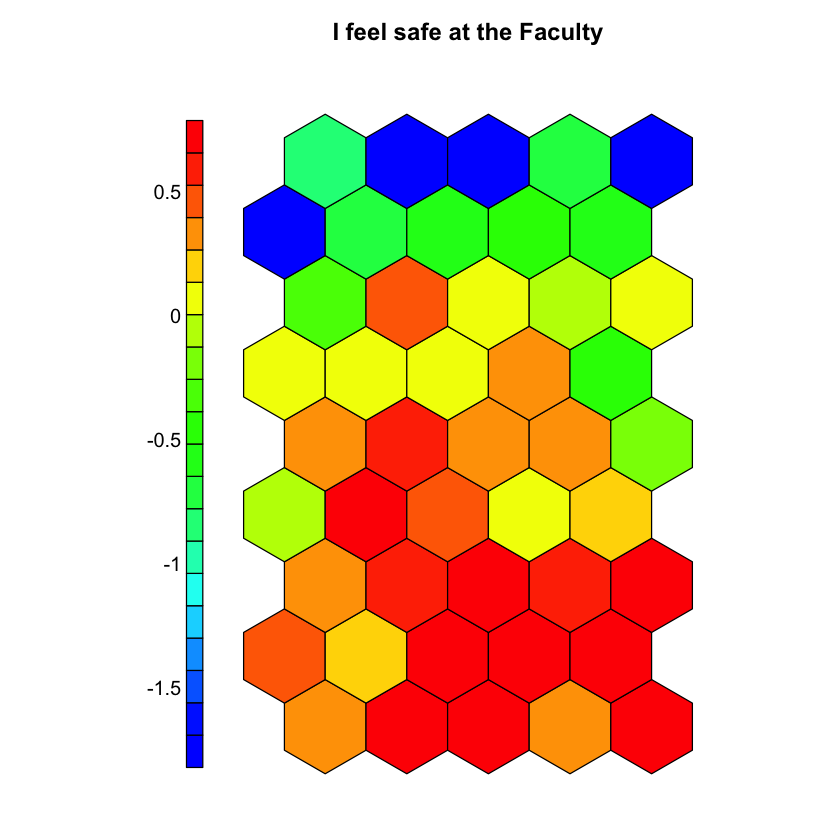

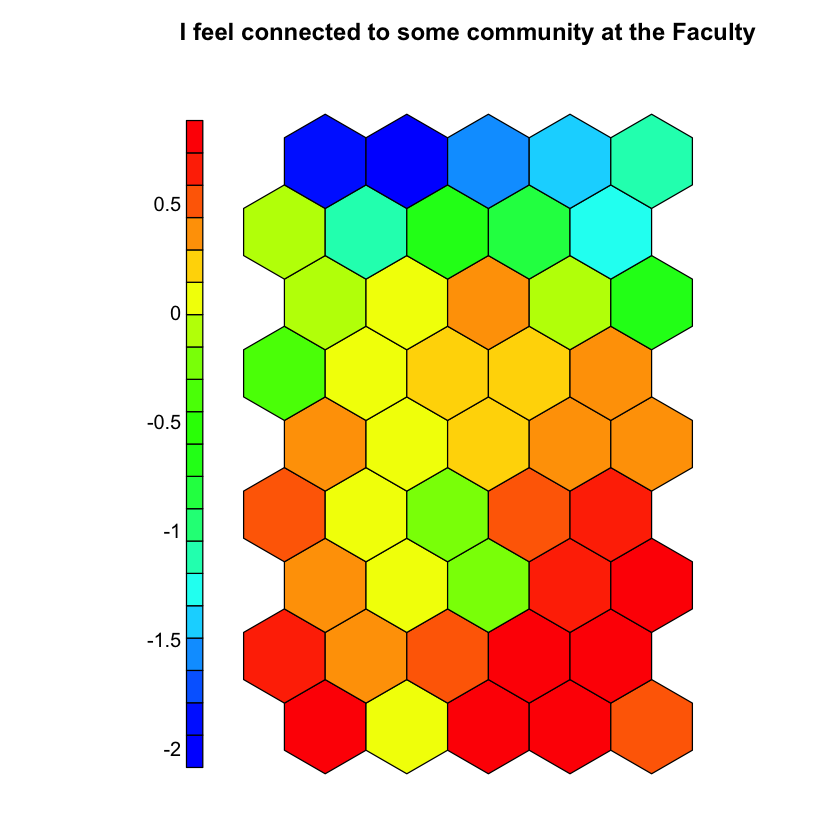

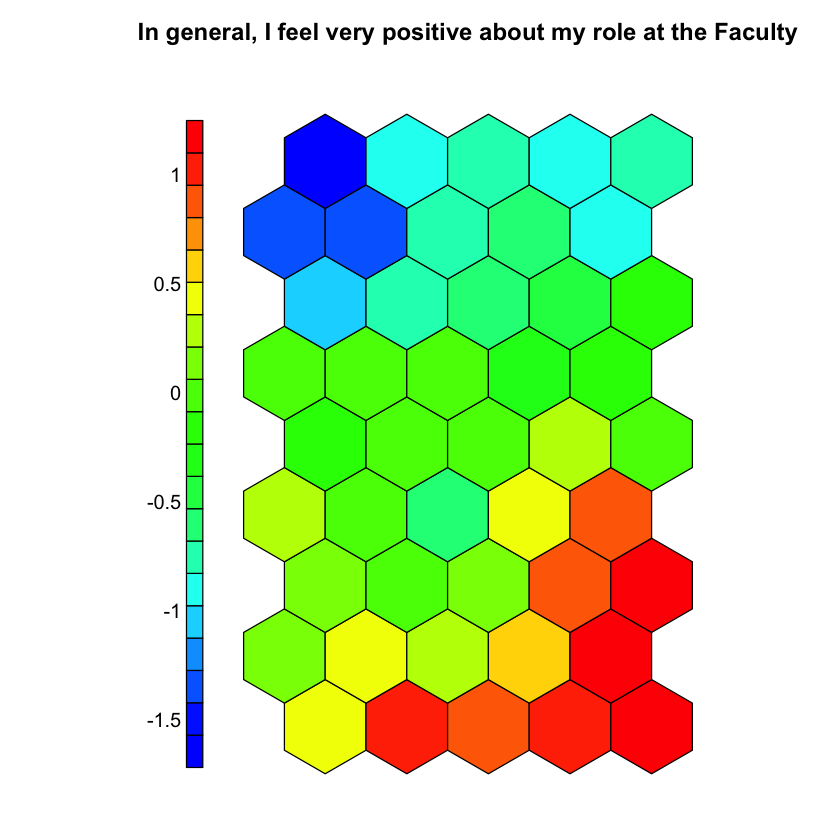

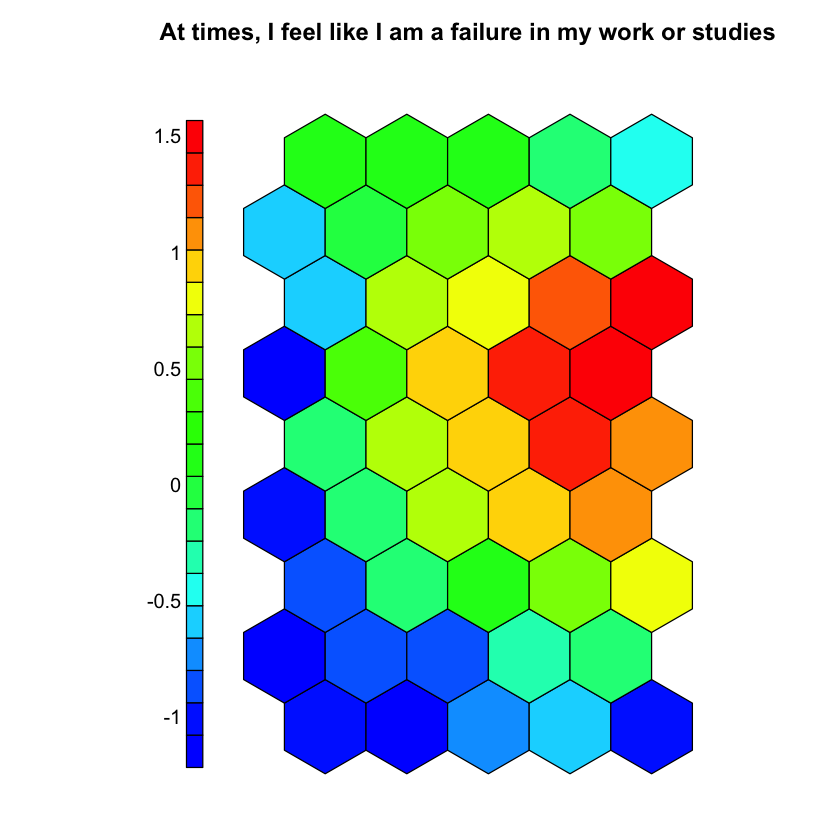

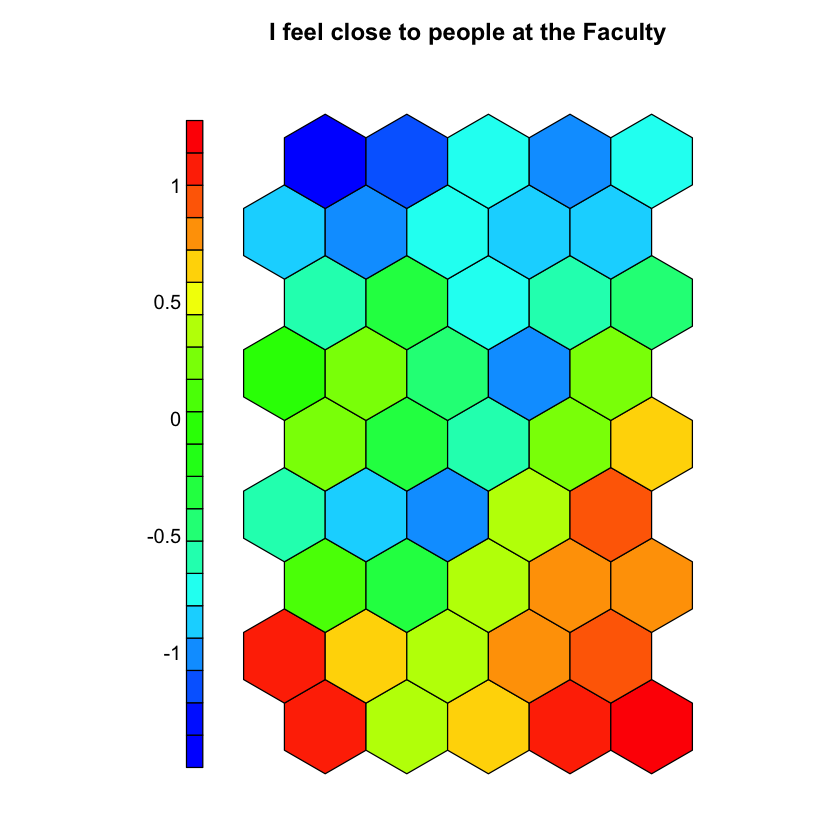

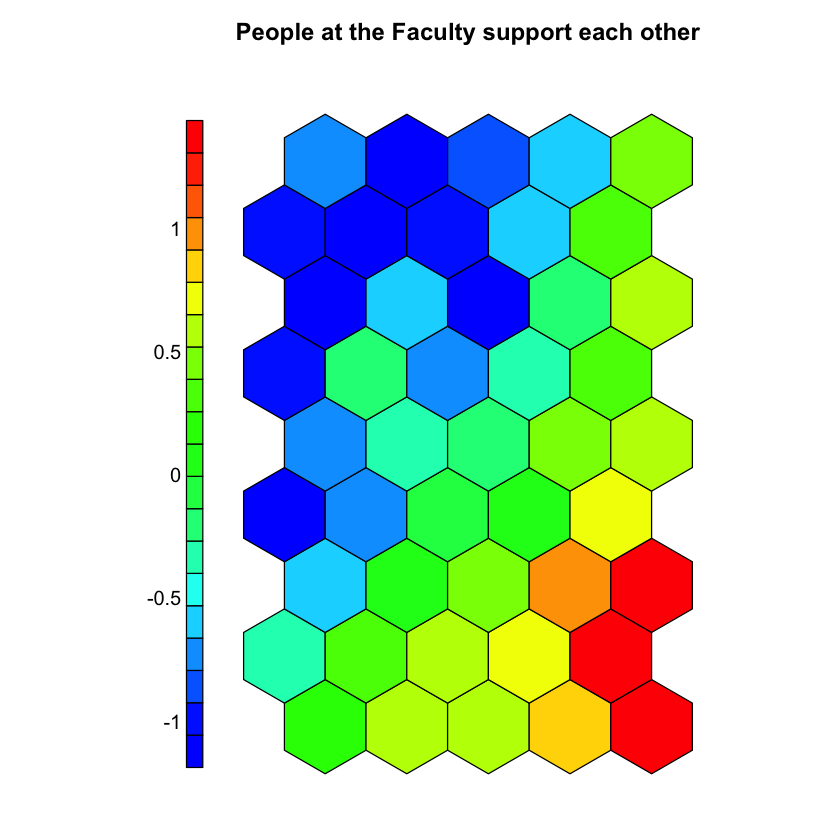

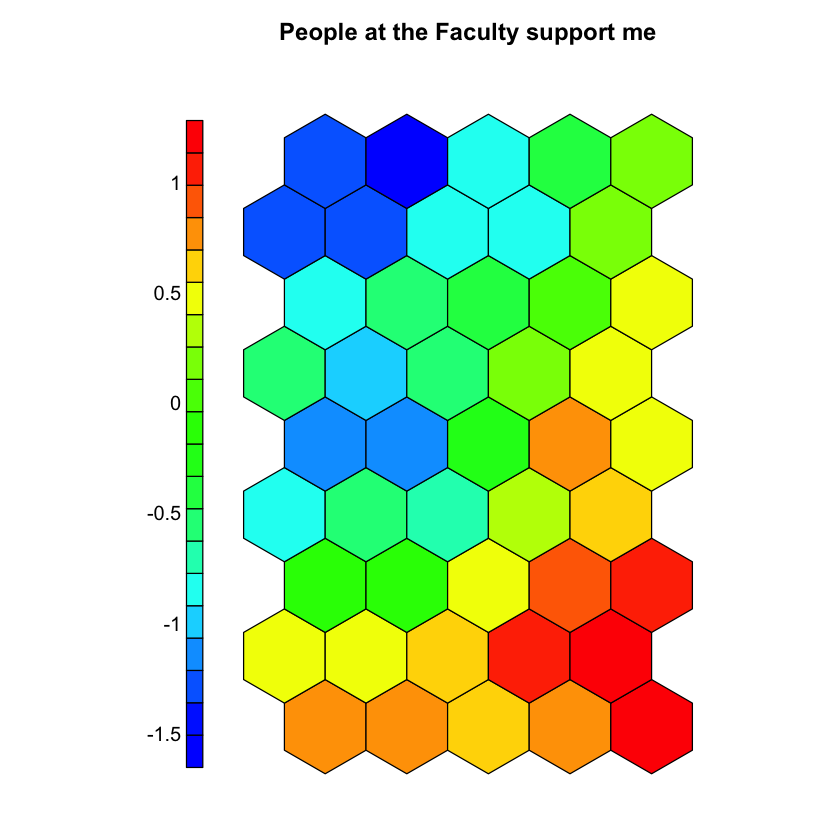

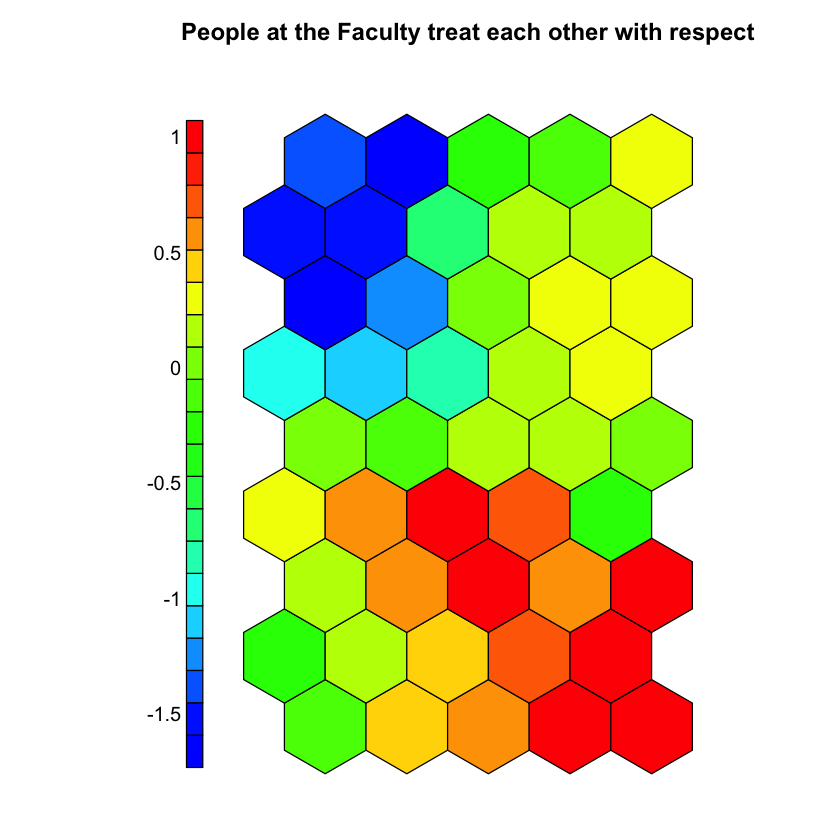

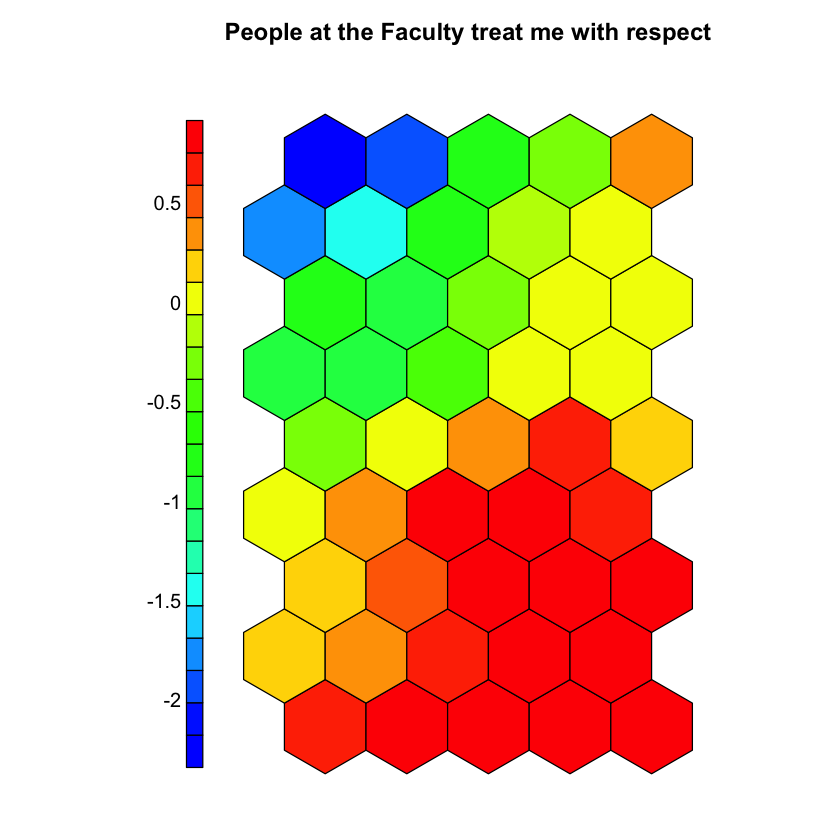

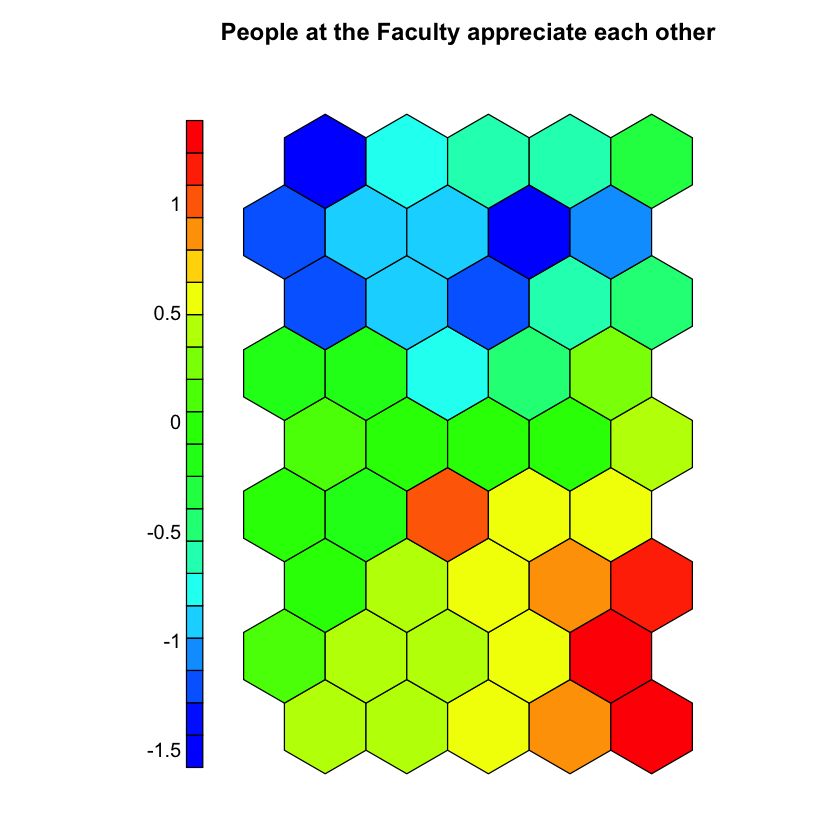

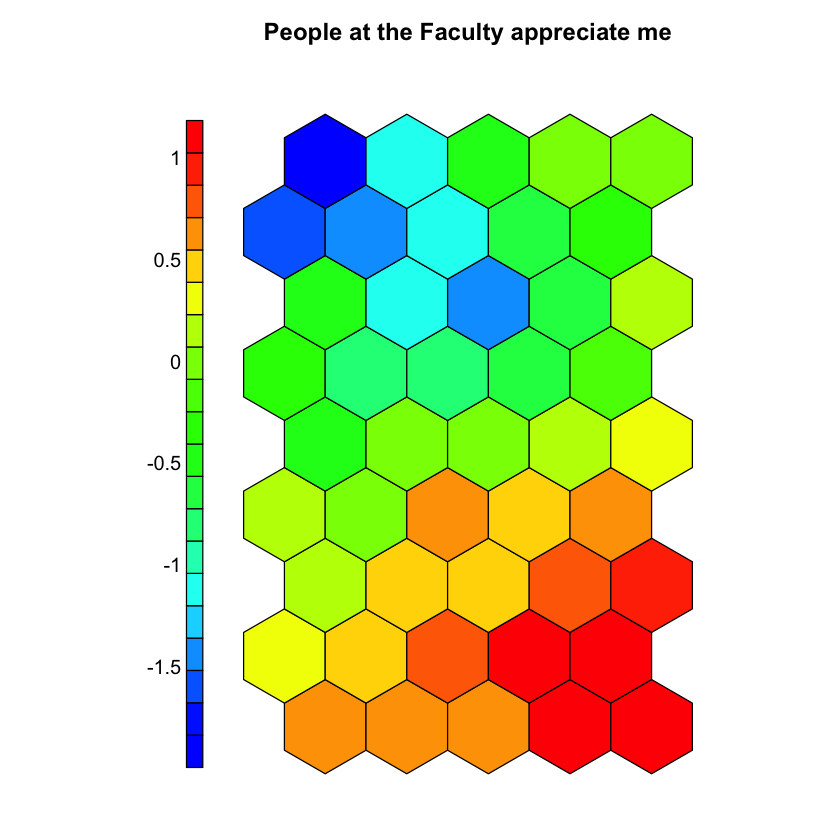

In [7]:
#heatmap for each question
set.seed(1118)
heatmap.som <- function(model, data){
  for (i in 1:ncol(data)) {
   plot(model, 
        type = "property", 
        palette.name = coolBlueHotRed,
        shape = "straight",
        property = getCodes(model)[,i], 
        main = get_label(data)[i]) #add colnames instead of get_label to add the names of the columns
  }
}

heatmap.som(som_model, data_train)

We should also check the quality of model.

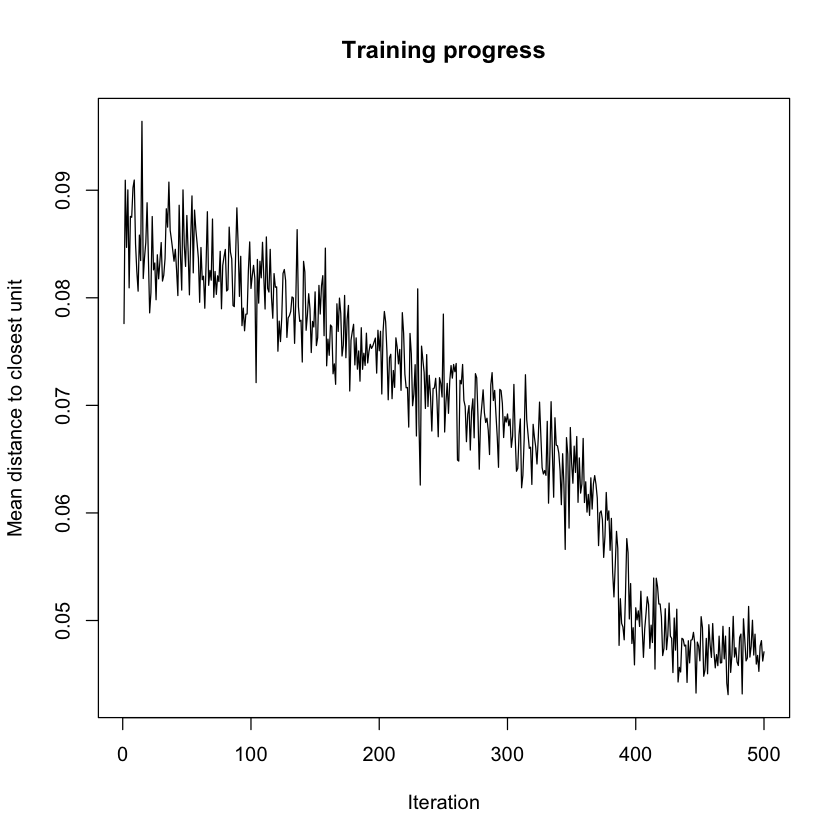

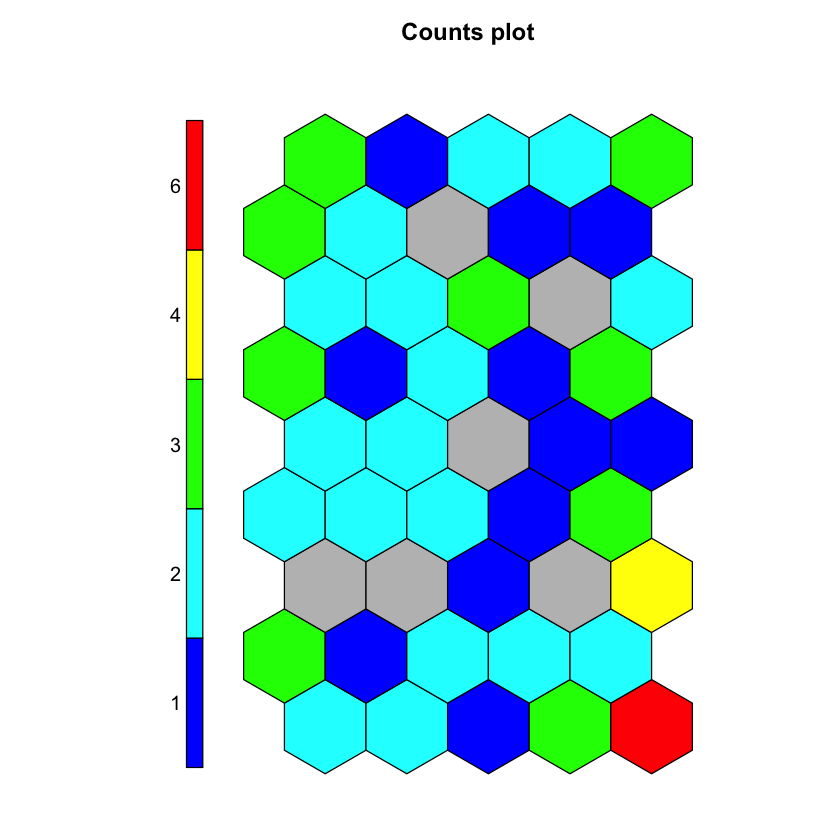

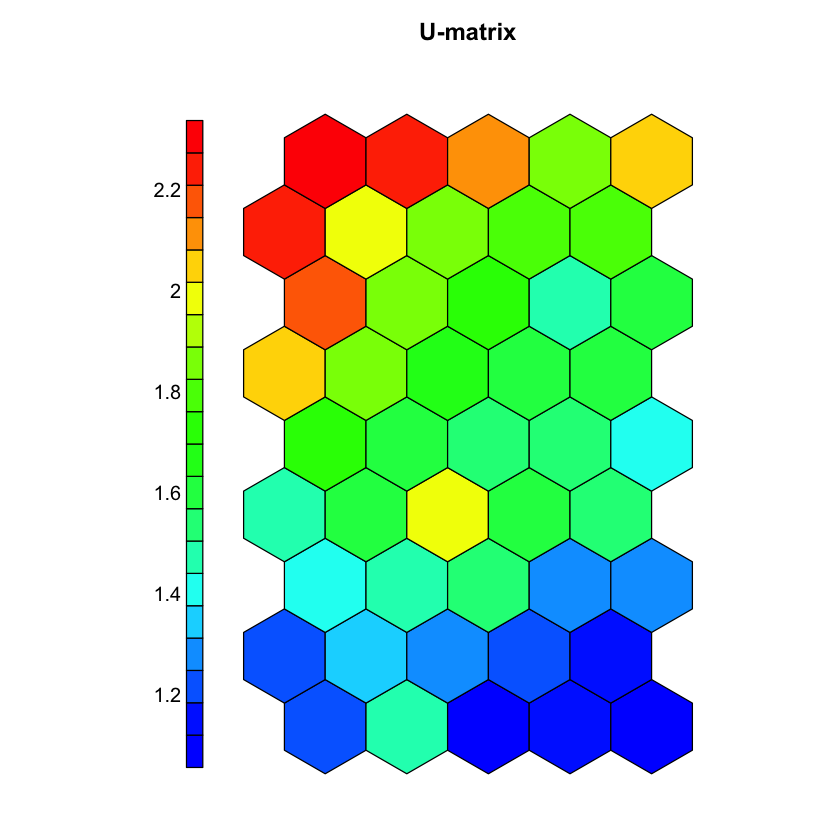

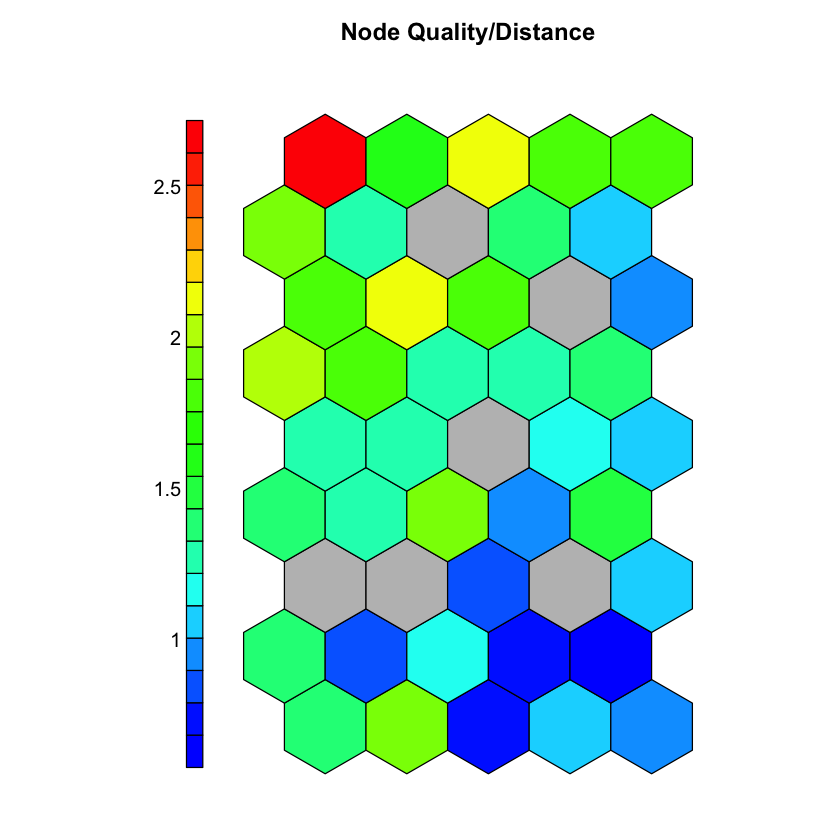

In [8]:
#check quality of model

set.seed(1118)
#training progress plot
plot(som_model, shape = "straight", type = "changes")

#node counts plot - how many samples are mapped to each node on the map
#ideally no empty nodes and no too large nodes, if yes -> change size of grid
plot(som_model, type = "counts",  shape = "straight", palette.name = coolBlueHotRed) 

#neighbours plot - U-matrix - distance matrix - check possible clusters

plot(som_model, type = "dist.neighbours", main = "U-matrix", shape = "straight", palette.name = coolBlueHotRed)


#codes plot - shows all variables at the same time
#plot(som_model, type="codes") #for up to 4-5 variables, otherwise not readable

#map quality - The smaller the distances, the better the objects are represented by the property vectors. 
plot(som_model, type = "quality", main="Node Quality/Distance", shape = "straight", palette.name=coolBlueHotRed)


## Clustering

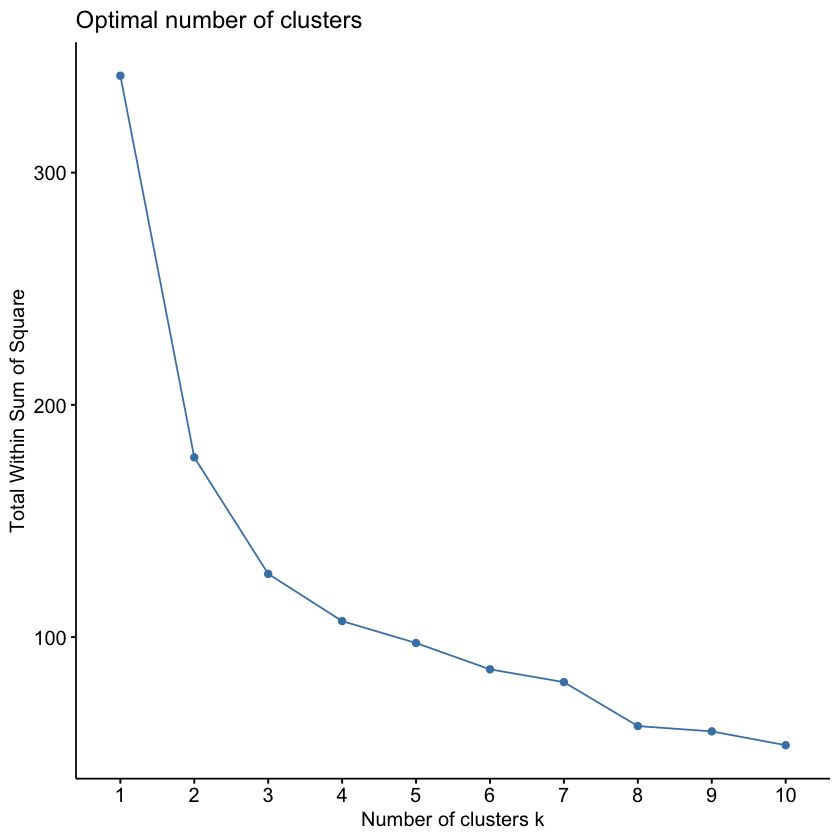

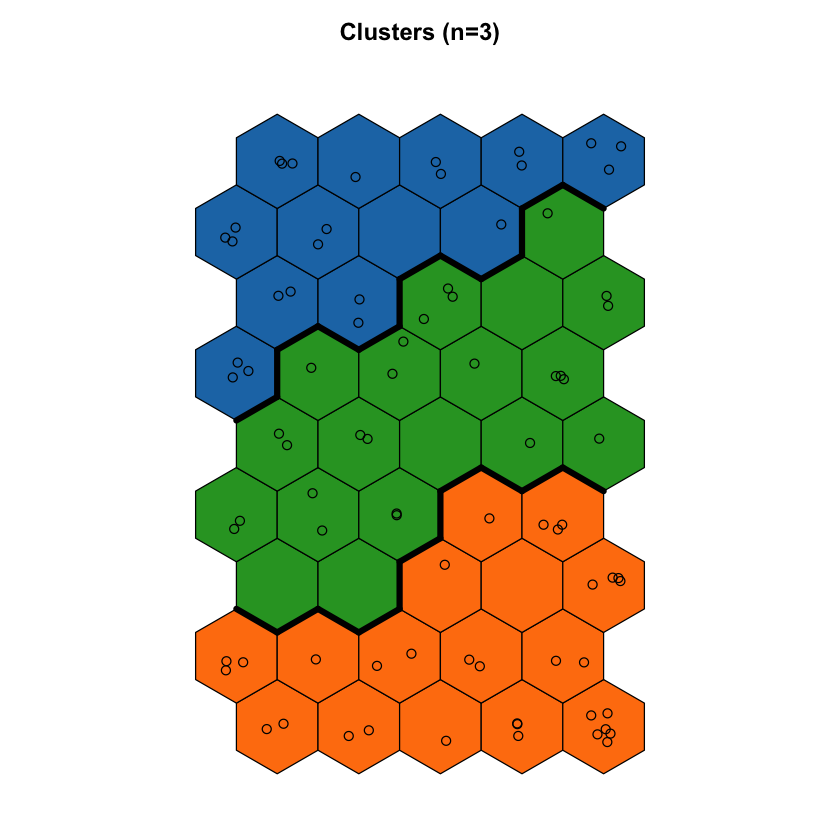

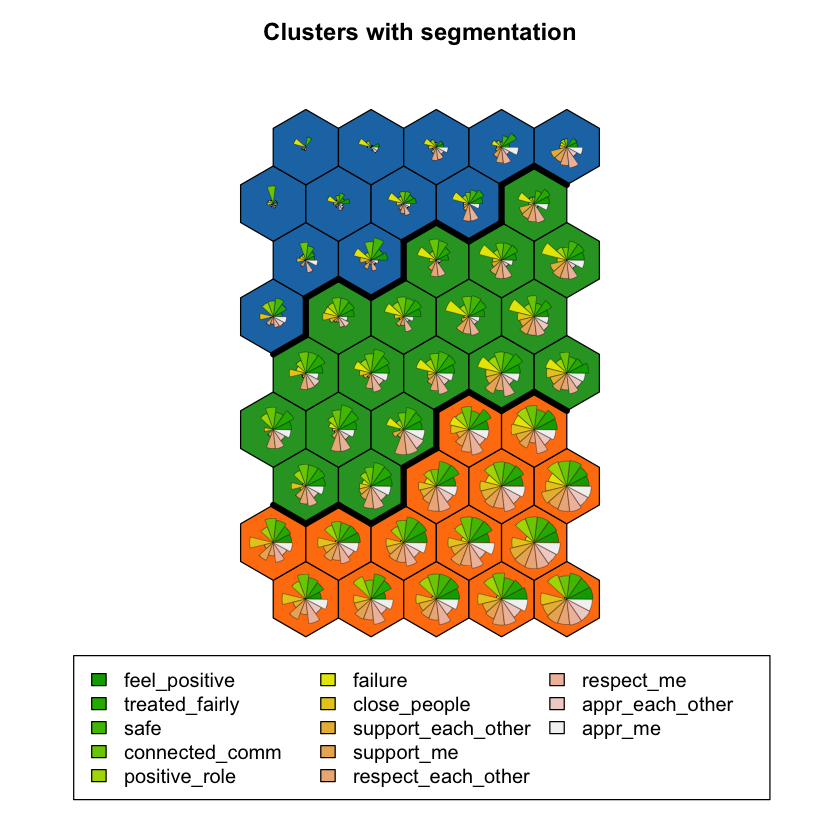

In [9]:
#check the best number of clusters with k-means
set.seed(1118)
fviz_nbclust(som_model$codes[[1]], kmeans, method = "wss") #Within-Cluster Sum of Square

## use k-means clustering to cluster the codebook vectors
clust <- kmeans(som_model$codes[[1]], 3)

# plot these results
plot(som_model, 
     type="mapping", 
     shape = "straight",
     bgcol = pretty_palette[clust$cluster], 
     main = "Clusters (n=3)")
add.cluster.boundaries(som_model,clust$cluster)

#show the same plot with the codes instead of just colours 
#limited number of variables
#suppressWarnings - to delete unnecessary warning
suppressWarnings(plot(som_model, 
                      type="codes", 
                      shape = "straight",
                      bgcol = pretty_palette[clust$cluster], 
                      main = "Clusters with segmentation"))
add.cluster.boundaries(som_model, clust$cluster)

## SOM with background and closed questions

Now we repeat the same analysis but also add closed questions. 
We scale data and create data matrix. 
Then we set the size of grid.

In [10]:
#create dataset for training
data_train1 <- data
head(data_train1)

Relationship_to_the_faculty Fluency_in_Finnish feel_positive treated_fairly
1 3                           5                  1             1             
2 1                           5                  4             2             
3 3                           5                  2             4             
4 1                           5                  4             5             
5 0                           5                  4             4             
6 4                           5                  5             5             
  safe connected_comm positive_role failure close_people support_each_other
1 5    1              1             2       1            2                 
2 5    4              2             4       4            4                 
3 5    3              3             1       2            2                 
4 5    5              5             4       4            5                 
5 4    3              4             5       2            4                 
6 5    5              5             1       5            5                 
  support_me respect_each_other respect_me appr_each_other appr_me
1 2          2                  1          2               2      
2 4          2                  3          2               3      
3 3          3                  3          3               3      
4 5          5                  5          5               5      
5 4          4                  4          3               4      
6 5          5                  5          5               5      
  Gender_Don’t want to answer Gender_Female Gender_Male Gender_Other
1 0                           0             1           0           
2 0                           1             0           0           
3 0                           1             0           0           
4 0                           1             0           0           
5 0                           1             0           0           
6 0                           0             1           0

In [11]:
#create data matrix and scale data
data_train_matrix1 <- as.matrix(scale(data_train1))

#set the size of grid

#size of grid is selected by the researcher usually 
#but one of the approaches to count the appropriate size is 5*sqrt(n) where n is number of observations(rows)

#set the size of grid
xdim1 <- 5
ydim1 <- 9

#create som grid
som_grid1 <- somgrid(xdim = xdim1, ydim = ydim1, neighbourhood.fct = "gaussian", topo="hexagonal")

We create second model with new variables number.

In [12]:
#create SOM model including NAs
set.seed(1119)
som_model1 <- supersom(data_train_matrix1, 
                      grid=som_grid1, 
                      rlen = 300, #set experimentally
                      alpha = c(0.05, 0.01),
                       dist.fcts = "euclidean",
                      maxNA.fraction = .9, 
                      keep.data = TRUE)


summary(som_model1)

SOM of size 5x9 with a hexagonal topology and a gaussian neighbourhood function.
The number of data layers is 1.
Distance measure(s) used: euclidean.
Training data included: 83 objects.
Mean distance to the closest unit in the map: 1.938.


Red colour presents the highest value for the variable, blue colour - the lowest.

Then we create the heatmap for each variable.

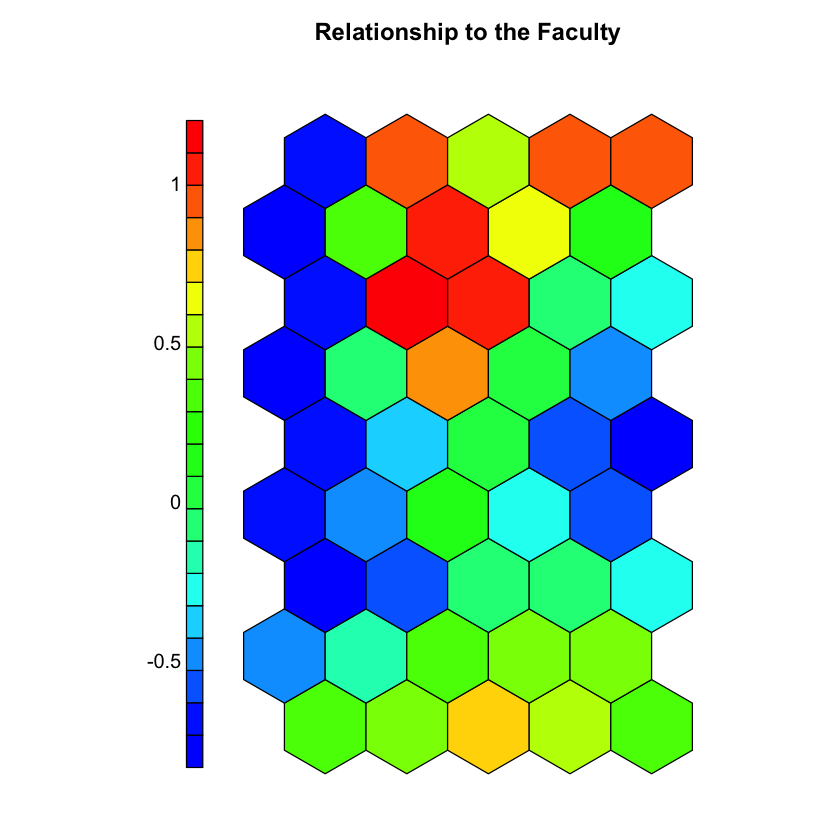

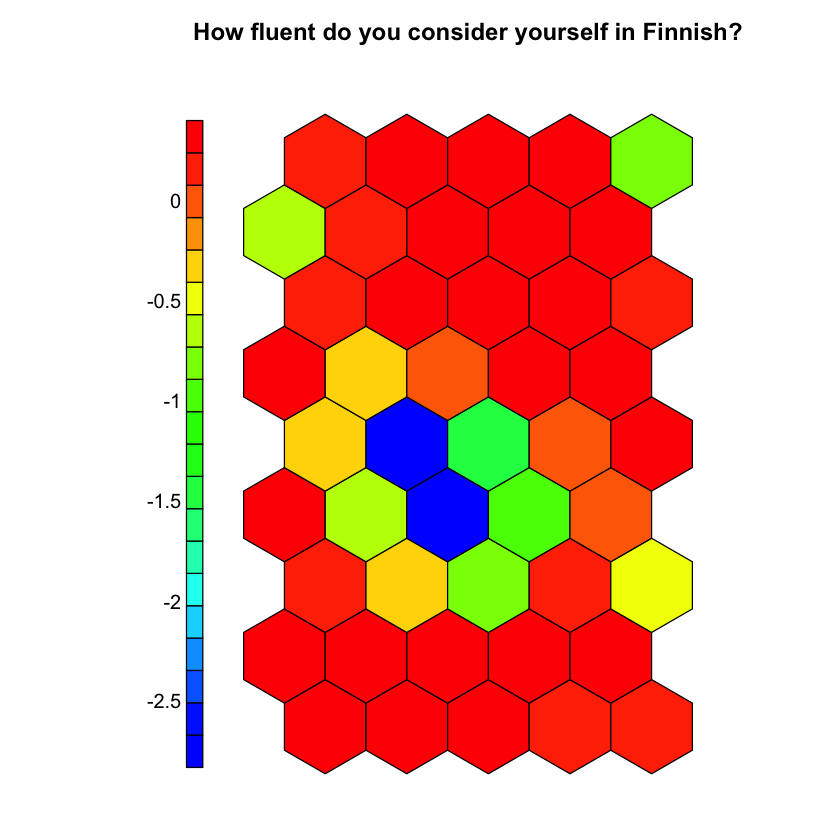

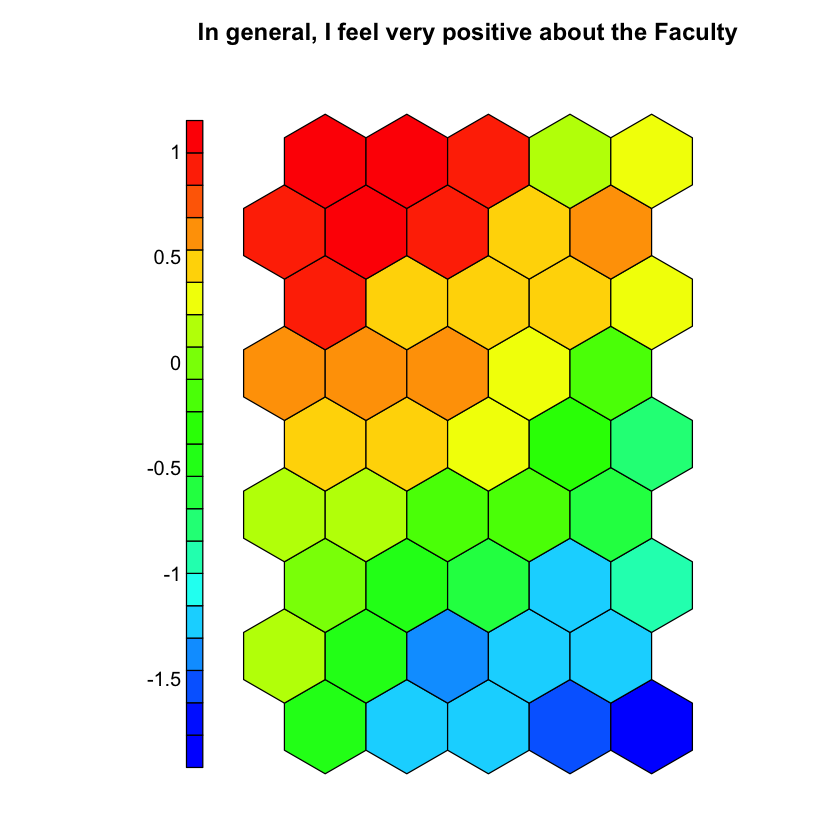

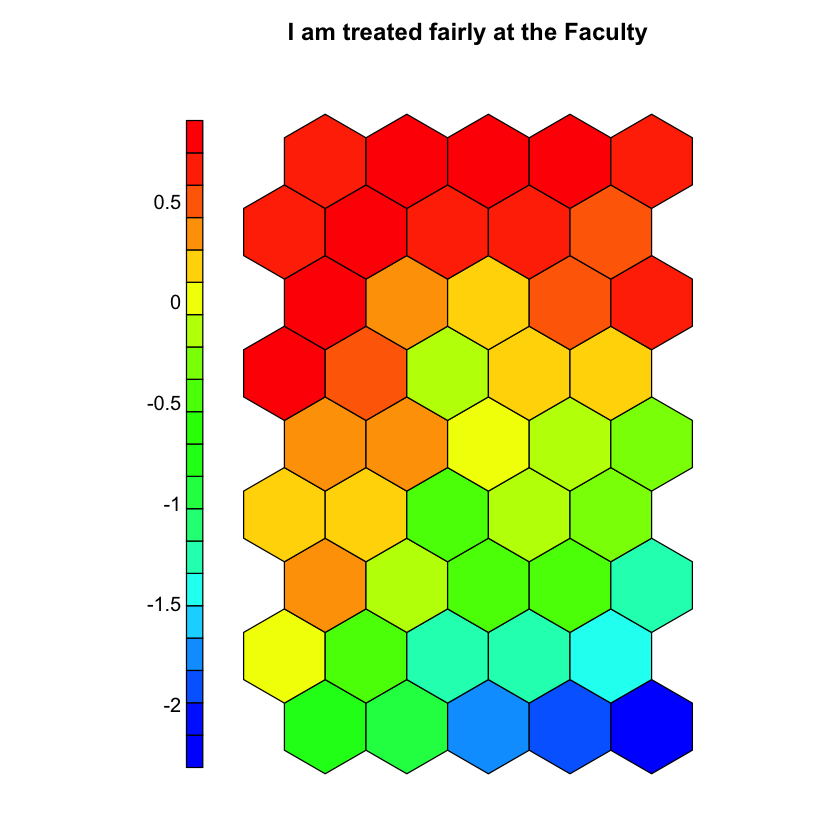

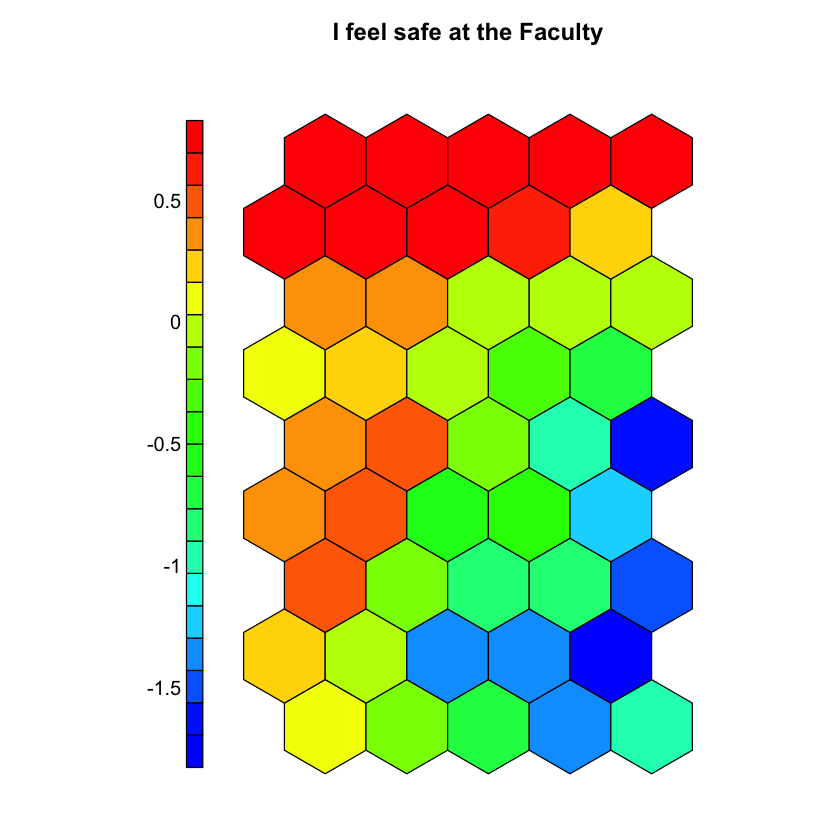

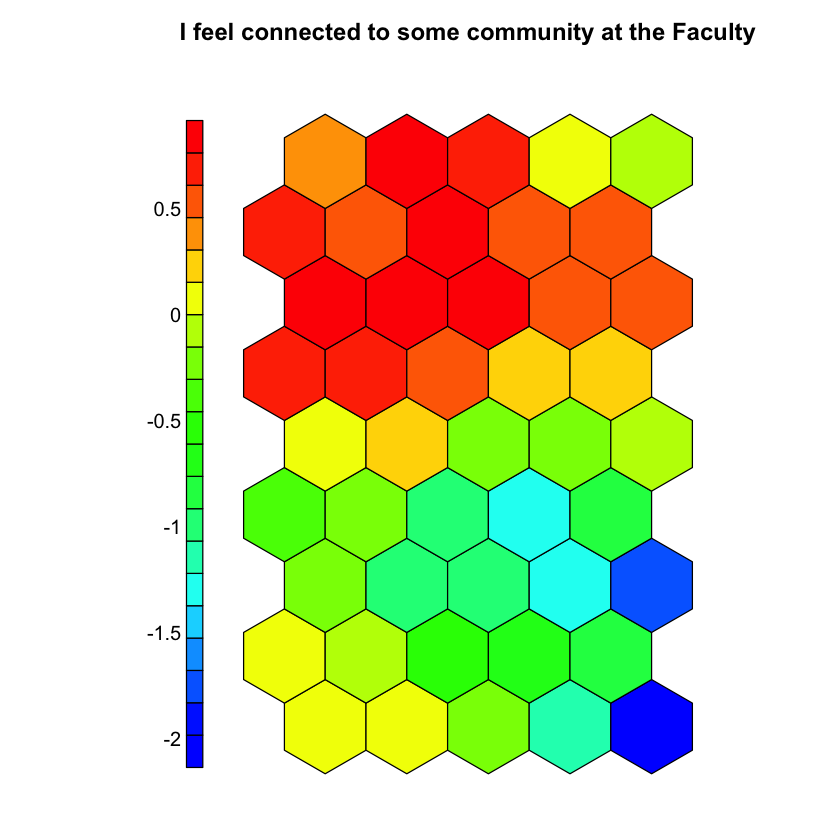

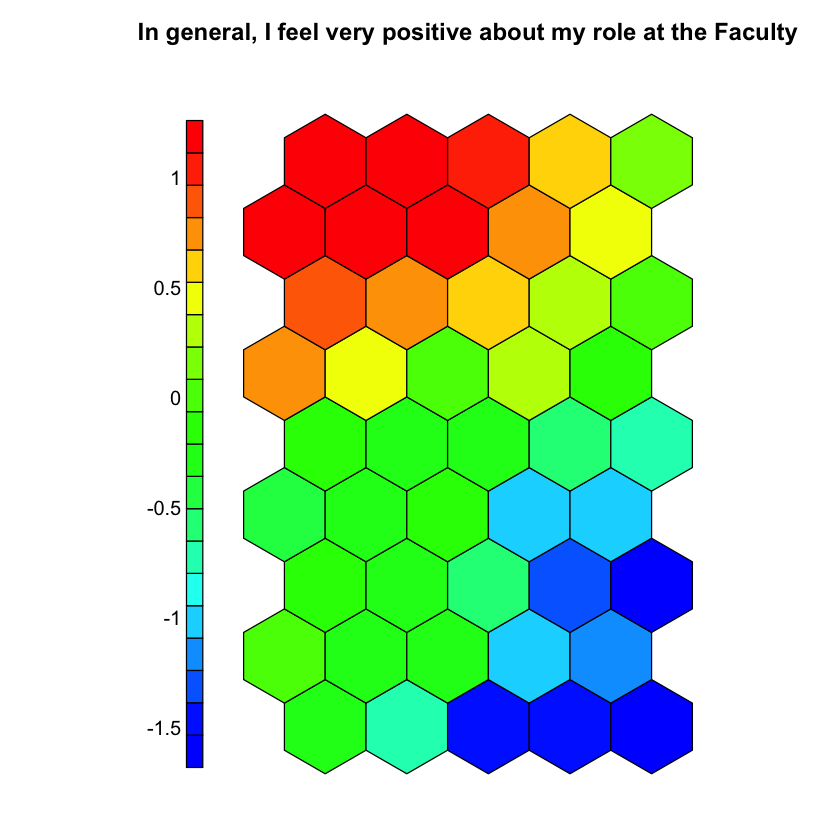

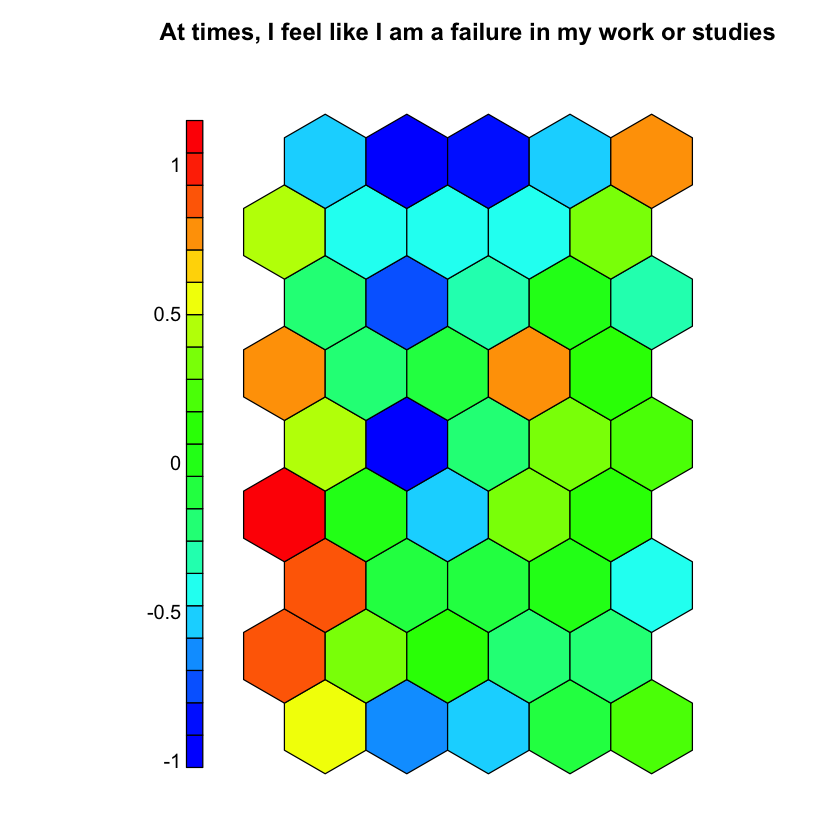

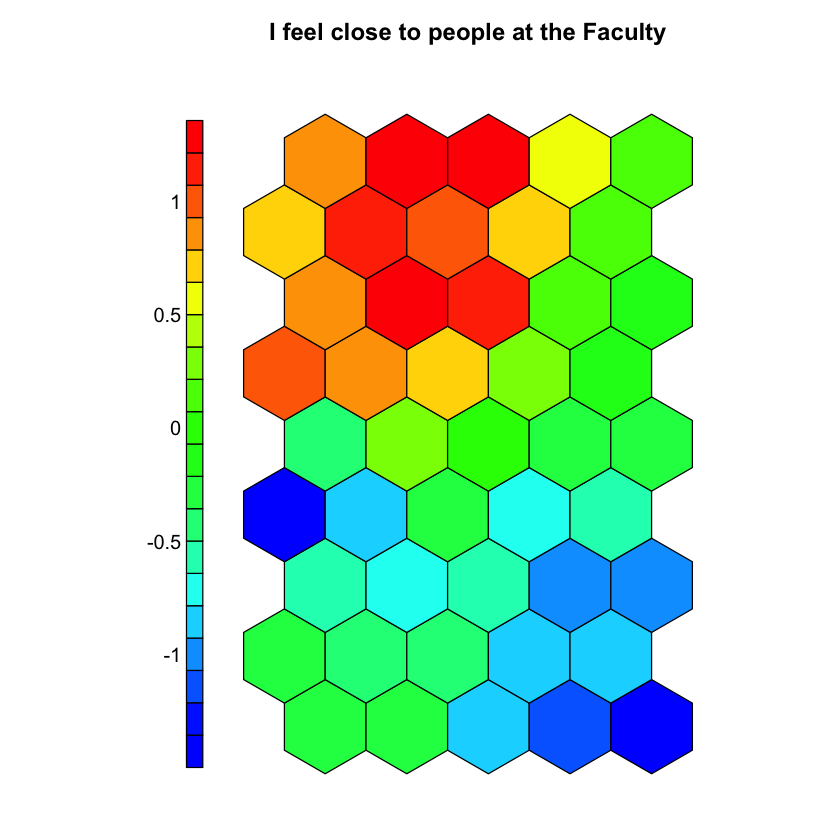

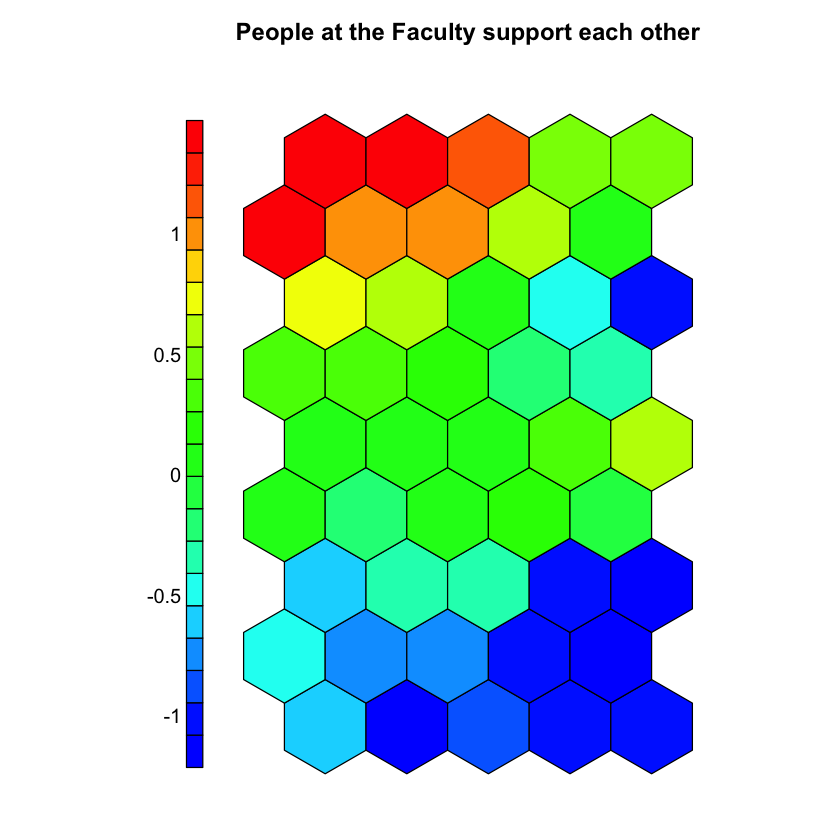

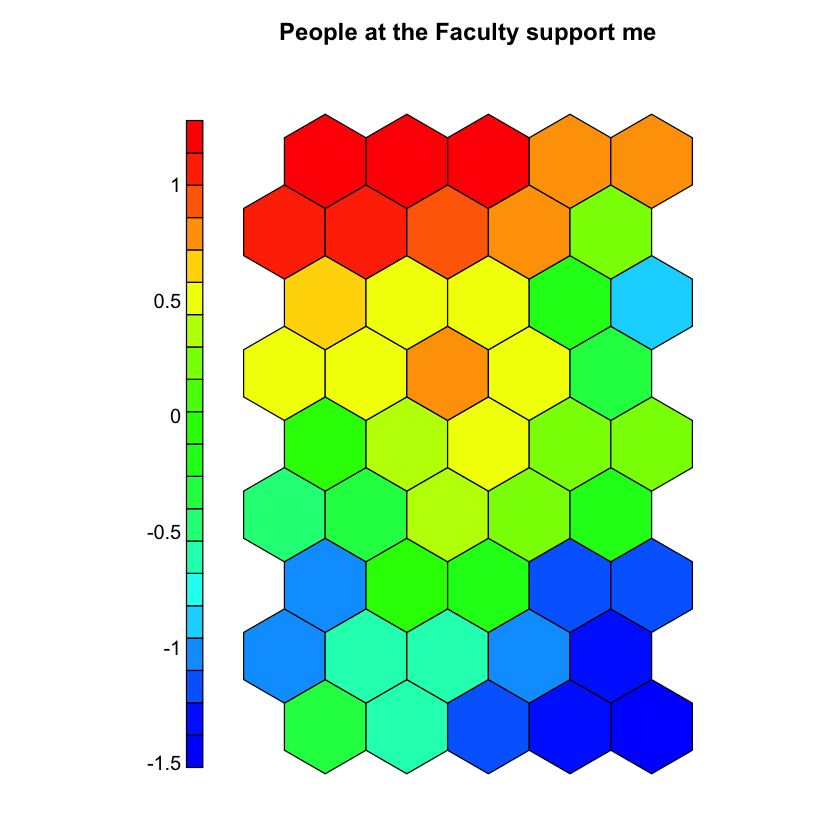

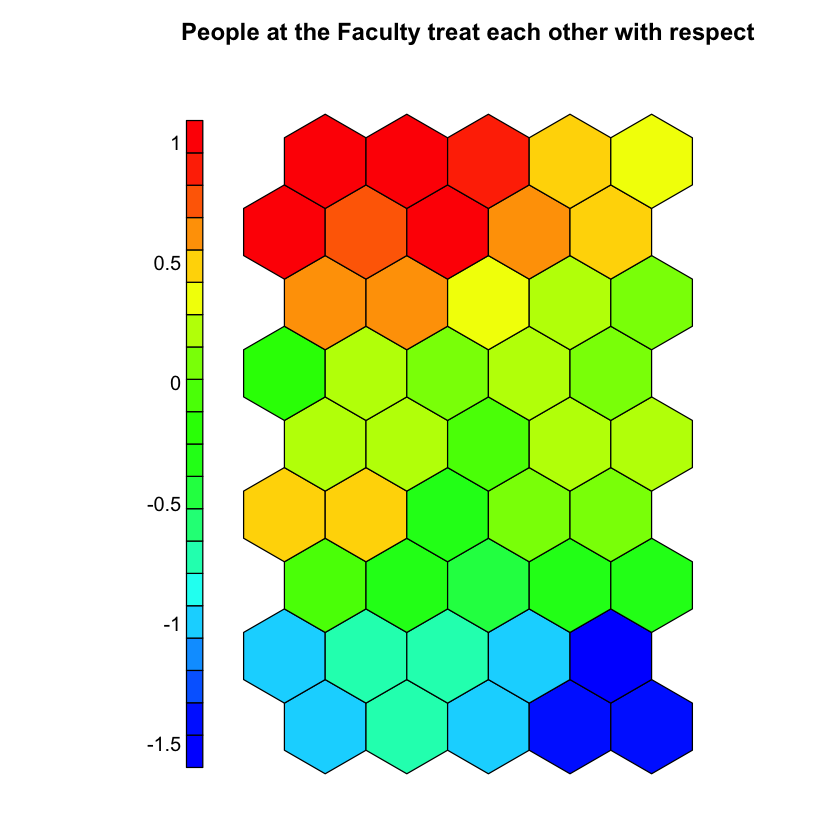

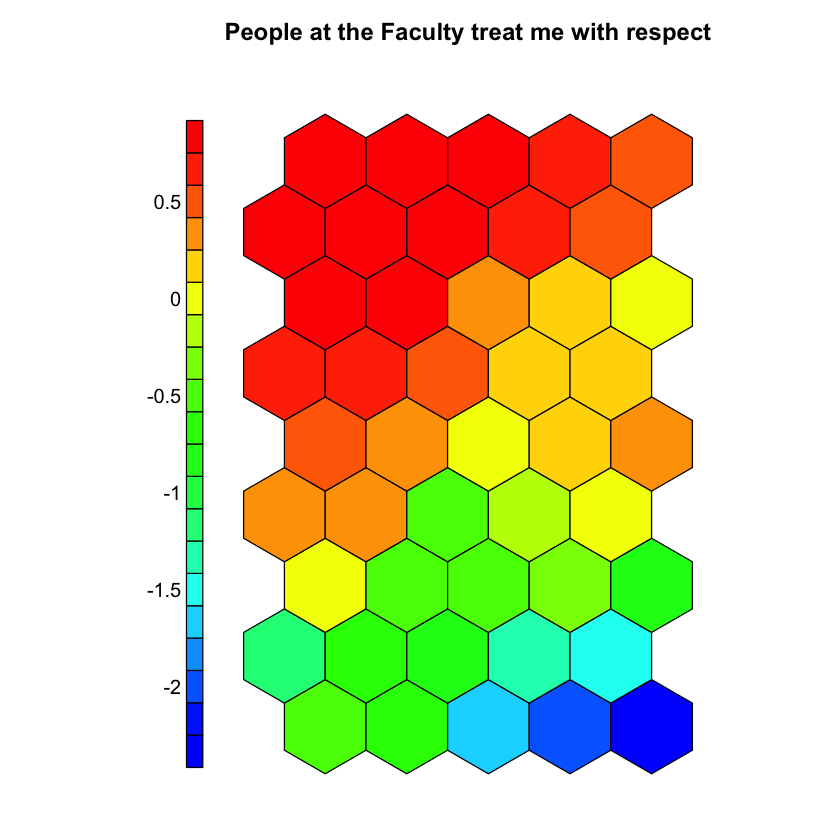

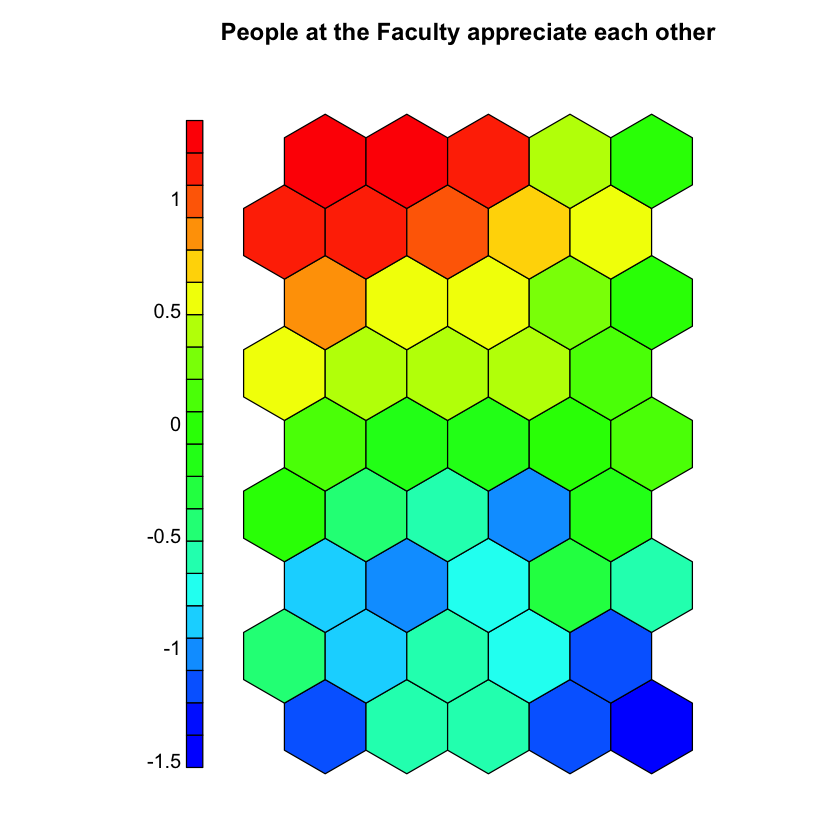

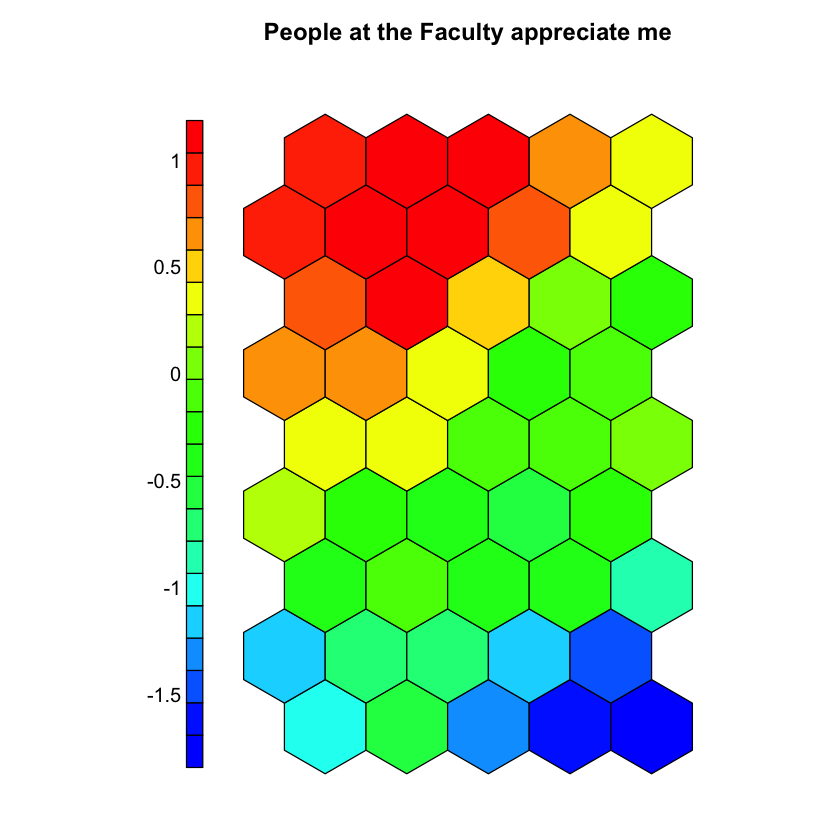

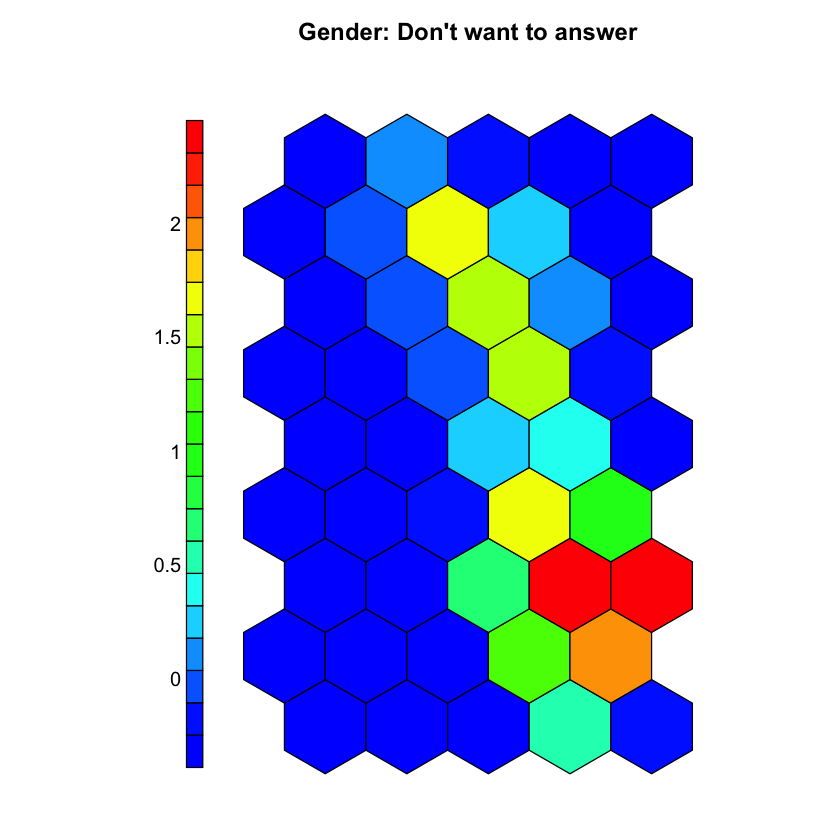

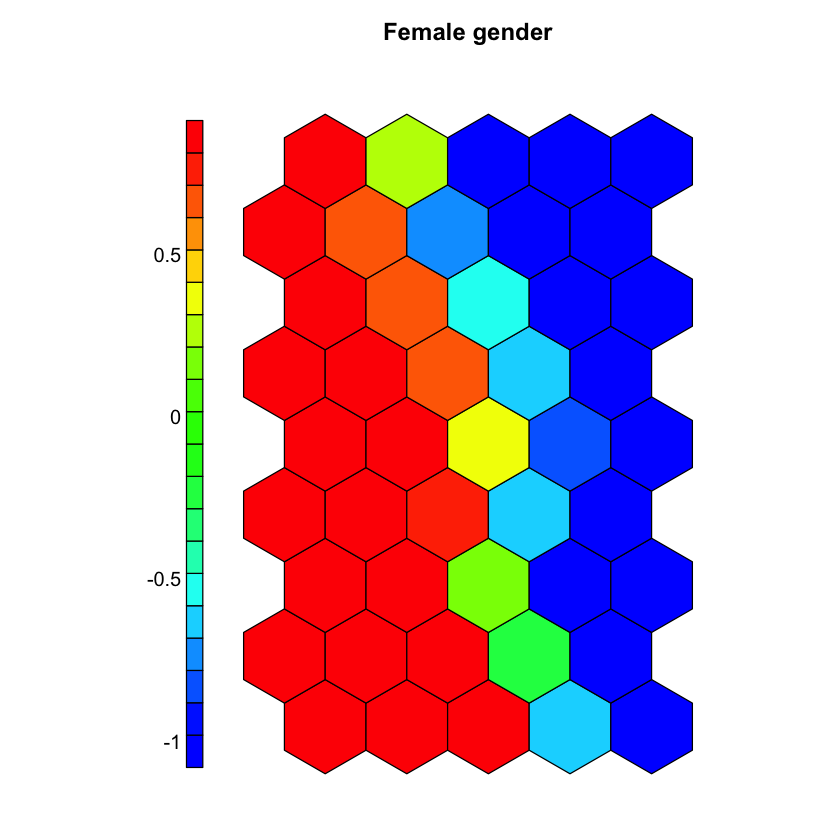

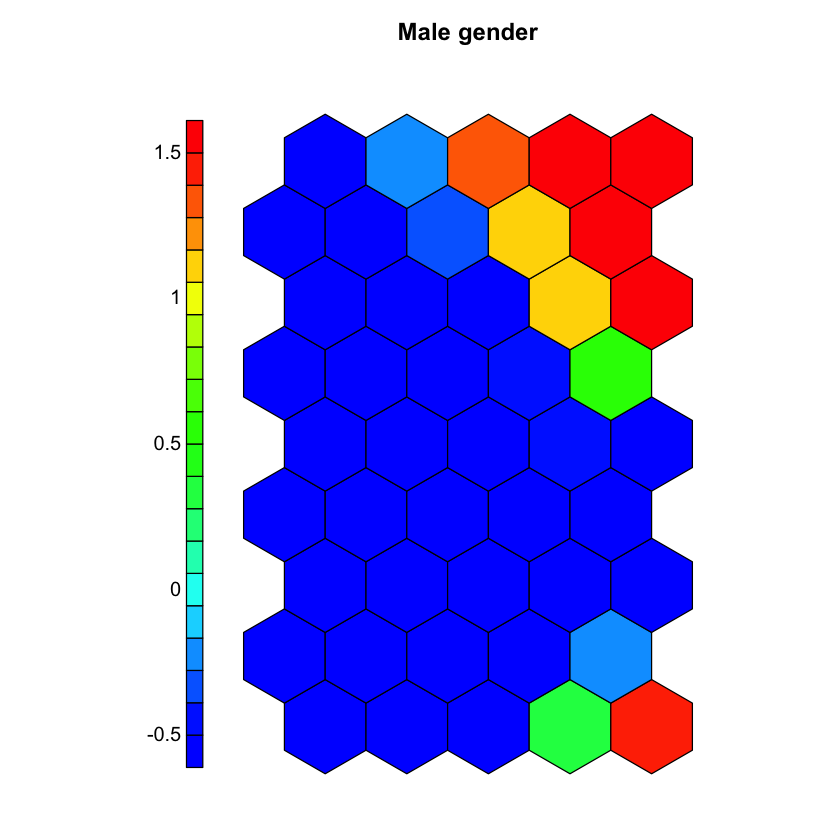

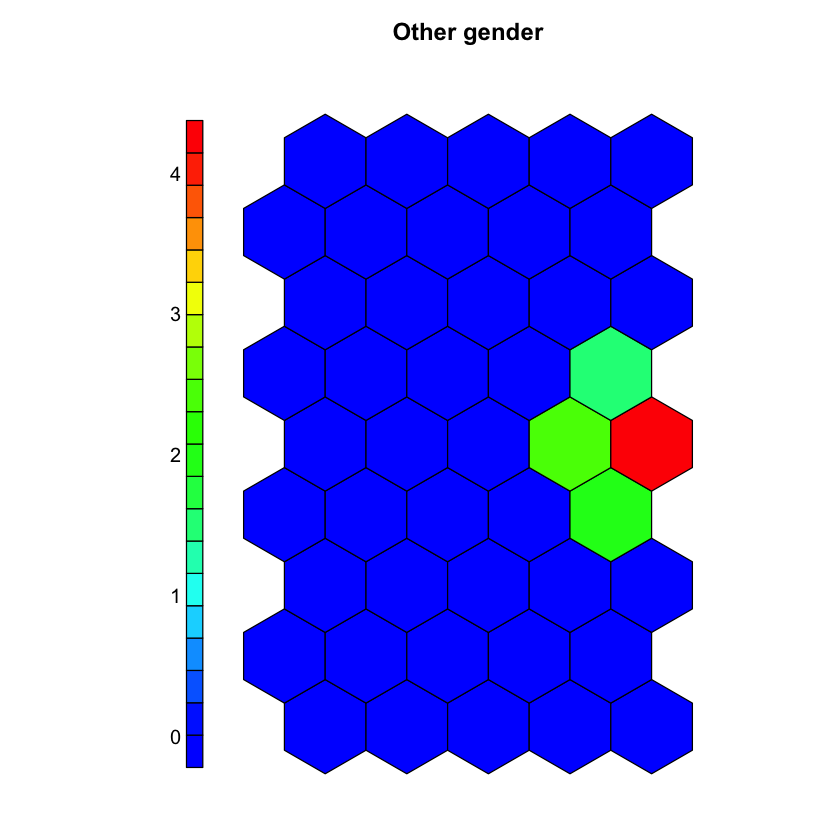

In [13]:
#heatmap for each question
set.seed(1119)
heatmap.som(som_model1, data_train1)


We can also check quality of model with several plots.

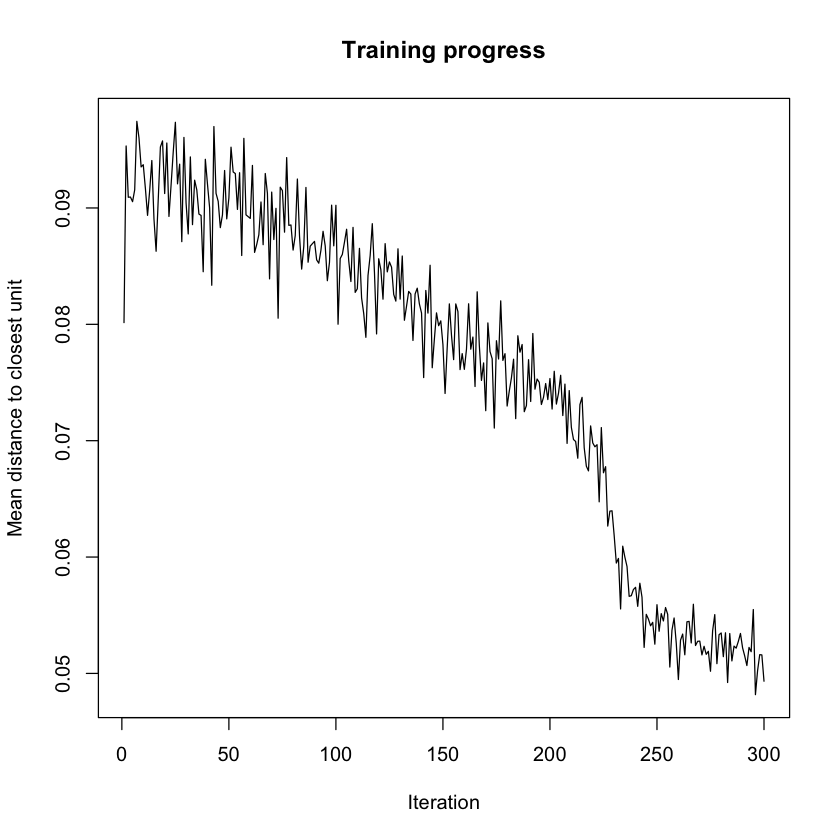

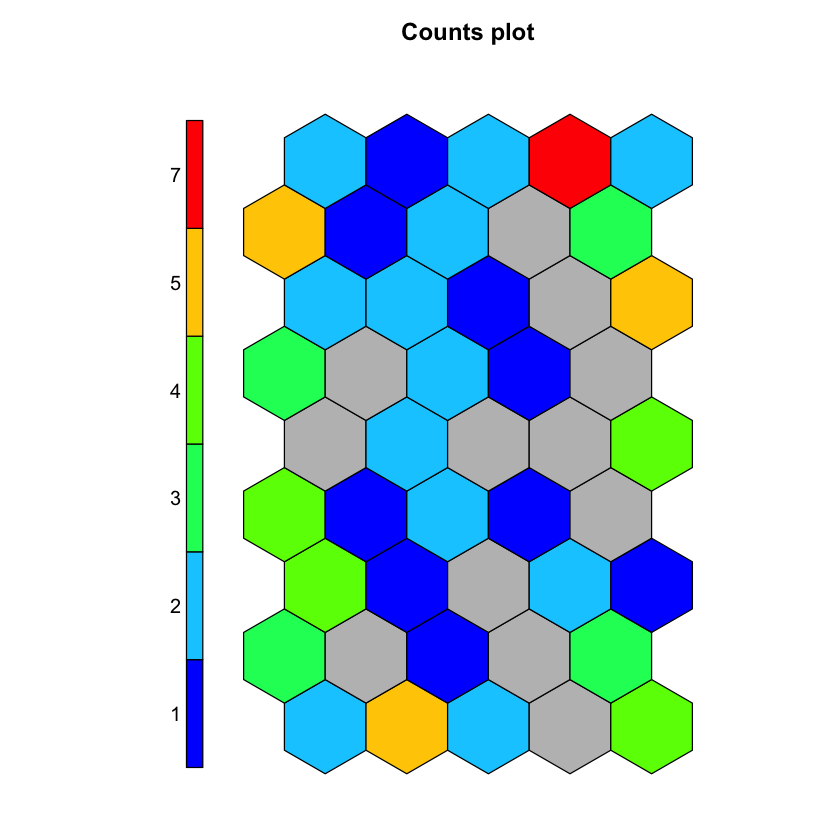

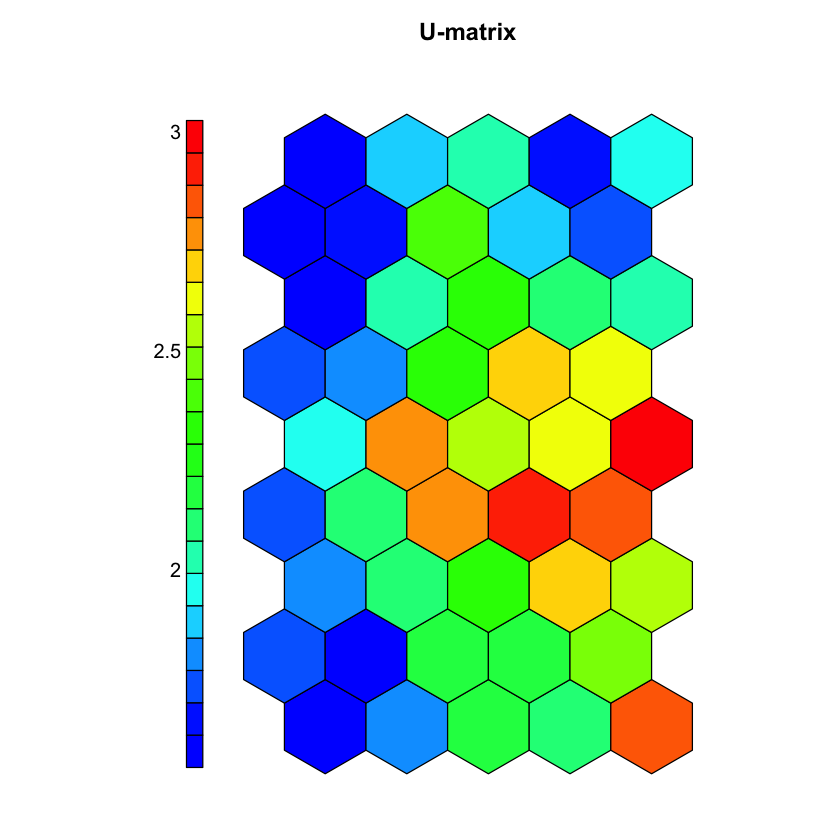

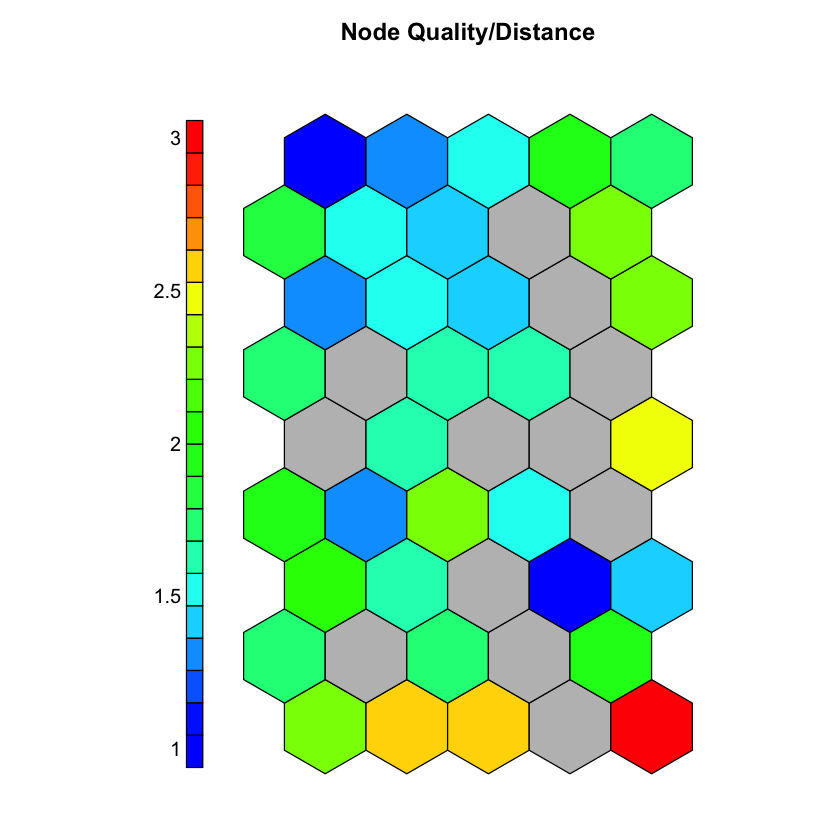

In [14]:
#check quality of model

set.seed(1119)
#training progress plot
plot(som_model1, shape = "straight", type = "changes")

#node counts plot - how many samples are mapped to each node on the map
plot(som_model1, type = "counts",  shape = "straight", palette.name = coolBlueHotRed) 

#neighbours plot - U-matrix - distance matrix
#U-matrix shows distances between neighboring units - each node in the u-matrix describes the Eucledian distance between nodes in the SOM. The highest (red) - large distance, smallest (blue) - small distance. Nodes that have blue colors mean that the nodes have a vector input that is closer, whereas nodes that have red colors mean that the nodes have vector inputs that are farther apart.
plot(som_model1, type = "dist.neighbours", main = "U-matrix", shape = "straight", palette.name = coolBlueHotRed)

#codes plot
#plot(som_model1, type="codes") #for up to 4-5 variables

#map quality
plot(som_model1, type = "quality", main="Node Quality/Distance", shape = "straight", palette.name=coolBlueHotRed)

## Clustering

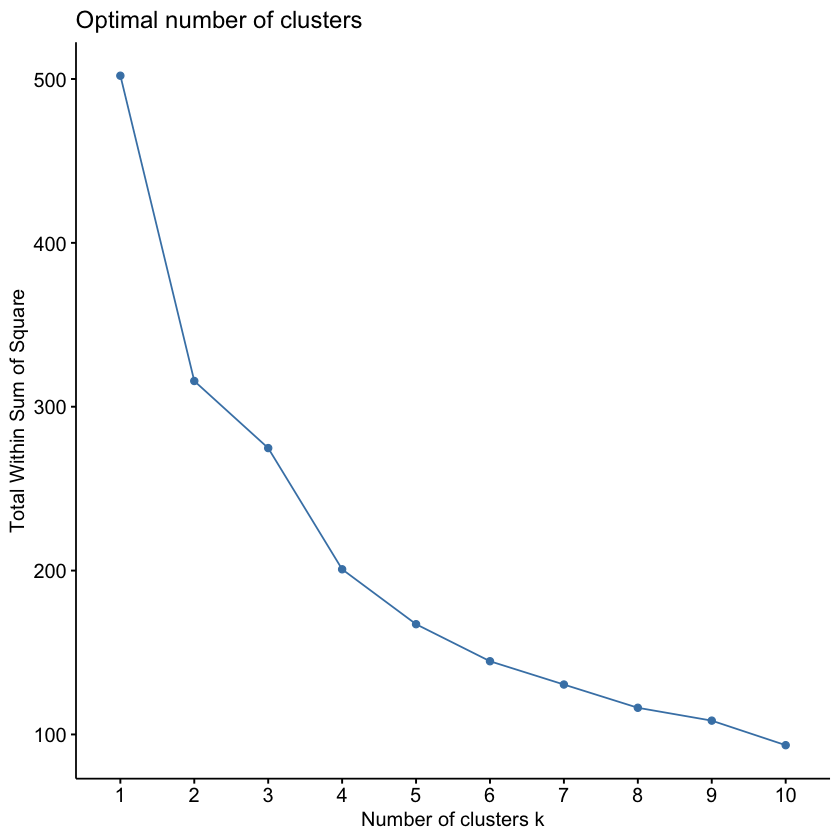

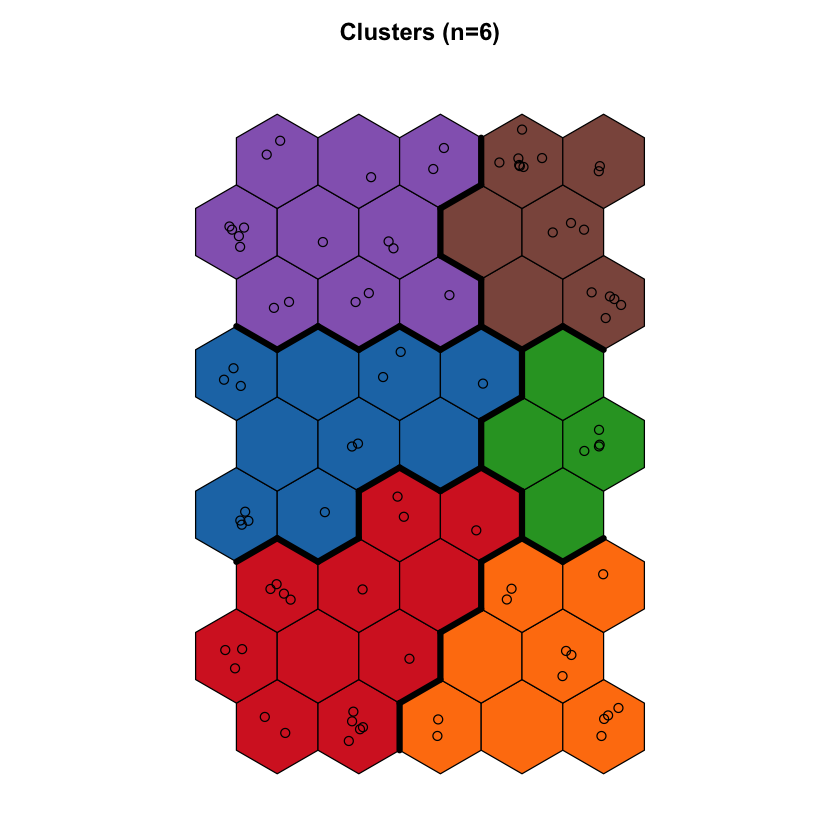

In [15]:
#check the best number of clusters with k-means
set.seed(1119)
fviz_nbclust(som_model1$codes[[1]], kmeans, method = "wss") #Within-Cluster Sum of Square

## use k-means clustering to cluster the prototype vectors and choose best number of clusters
clust1 <- kmeans(som_model1$codes[[1]], 6)

# plot these results:
plot(som_model1, 
     type="mapping",
     shape = "straight",
     bgcol = pretty_palette[clust1$cluster], 
     main = "Clusters (n=6)") 
add.cluster.boundaries(som_model1,clust1$cluster)


#show the same plot with the codes instead of just colours 
#for limited number of variables
#plot(som_model1, type="codes", shape = "straight", bgcol = pretty_palette[clust1$cluster], main = "Clusters")
#add.cluster.boundaries(som_model1, clust1$cluster)